# This is Cartography put together into one place. 

## Modules to add to run this code:

- [BioPython][1]
- [Pandas][2]
- [Numpy][3]
- [Altair][4]
- [Seaborn][5]
- [Scikit-Learn][6]
- [UMAP][7]
- json
- nextstrain-augur
[1]:https://biopython.org/wiki/Download
[2]:https://pandas.pydata.org/pandas-docs/version/0.23.3/install.html
[3]:https://docs.scipy.org/doc/numpy/user/quickstart.html
[4]:https://altair-viz.github.io/getting_started/installation.html
[5]:https://seaborn.pydata.org/installing.html
[6]:https://scikit-learn.org/stable/install.html
[7]:https://umap-learn.readthedocs.io/en/latest/


# Imports Section 

In [1]:
import pandas as pd
import altair as alt
import numpy as np
from scipy.spatial.distance import squareform, pdist
import pandas as pd
import numpy as np
from Bio import SeqIO
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from augur.utils import json_to_tree
import json
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap
from scipy.stats import linregress
from pathlib import Path

# METHODS SECTION
- All the methods I use throughout this notebook is all together up here. 

### Taking the result strains from reading in the metadata and concatenating it to the principal components (where each row is joined with one genome)

In [2]:
"""
principal_Df -- Data from data reduction (-T-SNE, MDS, etc) (pandas DataFrame)
result_metadata -- the metadata that is being read in (Pandas DataFrame)
fields, the parts of metadata that should be concatenated with princiapl_Df (list)
"""
def concatenate_results_with_strain_data(principal_Df,result_metadata,fields):
    finalDf = pd.concat([principal_Df, result_metadata[fields]], axis = 1)
    return finalDf

### Altair method for easy tooltip/brushing below

In [3]:
"""
Defining Fields:
finalDf: The data that is used to generate the scatter plot (pandas DataFrame)
x, the data you want on the x axis (string)
y, the data you want on the y axis (string)
Titlex,the name you want on the x axis (string)
Titley, the name you want on the y axis (string)
Tooltip, when scanning over a point, the data you want avaiable (list)
Color, what the scatterplot is colored by (String)
"""
def scatterplot_with_tooltip_interactive(finalDf,x,y,Titlex,Titley,ToolTip,color):
    brush = alt.selection(type='interval', resolve='global')
    chart = alt.Chart(finalDf).mark_circle(size=60).encode(
        x=alt.X(x,title=Titlex),
        y=alt.X(y,title=Titley),
        color=color,
        tooltip=ToolTip
    ).interactive()
    chart.display()
    #return chart

### Linking tree with plots brush

In [4]:
"""
dataframe: dataframe including node data and dimensionality reduction data (Pandas Dataframe)
list_of_data: list of all the names of the columns in the dataframe for which you want graphs: goes in the order of [x1,y1,x2,y2,x3,y3] etc.(list)
list_of_titles: list of all the TITLES you want for each axis: goes in order of[x1,y1,x2,y2,x3,y3] etc.(list)
color: what the data should be colored by (string)
ToolTip: when hovering over the data, what data should be shown (list)
"""
def linking_tree_with_plots_brush(dataFrame,list_of_data,list_of_titles,color,ToolTip):
    list_of_chart = []
    if(len(list_of_data) % 2 != 0 or len(list_of_titles) % 2 != 0):
        raise Exception('The length of list_of_data and the length of list_of_titles should not be odd.')
    else:
        base = alt.Chart(dataFrame)
        brush = alt.selection(type='interval', resolve='global')
        tree_name = base.mark_circle().encode(
            x=alt.X(
                "date:Q",
                scale=alt.Scale(domain=(dataFrame["date"].min() - 0.2, dataFrame["date"].max() + 0.2)),
                title="Date"
            ),
            y=alt.Y(
                "y:Q",
                title=""
            ),
            color=alt.condition(brush, color, alt.ColorValue('gray')),
            tooltip=ToolTip
        ).add_selection(brush).properties(width=400,height=250)
        list_of_chart.append(tree_name)
        
        for i in range(0,len(list_of_data) - 1,2):
            if(i == len(list_of_data)):
                break
            chart = base.mark_circle(size=60).encode(
            x=alt.X(list_of_data[i],title=list_of_titles[i]),
            y=alt.X(list_of_data[i + 1],title=list_of_titles[i + 1]),
            color=alt.condition(brush, color, alt.ColorValue('gray')),
            tooltip=ToolTip
            ).add_selection(
                brush
            ).properties(
                width=250,
                height=250
            )
            list_of_chart.append(chart)
        return list_of_chart

### Linking Tree with Plots Clickable

In [5]:
def linking_tree_with_plots_clickable(dataFrame,list_of_data,list_of_titles,colors,fields,ToolTip):
    list_of_chart = []
    if(len(list_of_data) % 2 != 0 or len(list_of_titles) % 2 != 0):
        raise Exception('The length of list_of_data and the length of list_of_titles should not be odd.')
    else:
        base = alt.Chart(dataFrame)
        selection = alt.selection_multi(fields=fields)

        color = alt.condition(selection,
                              alt.Color(colors,legend=None),
                              alt.value('lightgray'))
        tree_name = base.mark_circle().encode(
            x=alt.X(
                "date:Q",
                scale=alt.Scale(domain=(dataFrame["date"].min() - 0.2, dataFrame["date"].max() + 0.2)),
                title="Date"
            ),
            y=alt.Y(
                "y:Q",
                title=""
            ),
            color=color,
            tooltip=ToolTip
        ).add_selection(selection).properties(width=400,height=250)
        
        list_of_chart.append(tree_name)
        for i in range(0,len(list_of_data) - 1,2):
            if(i == len(list_of_data)):
                break
            chart = base.mark_circle(size=60).encode(
            x=alt.X(list_of_data[i],title=list_of_titles[i]),
            y=alt.X(list_of_data[i + 1],title=list_of_titles[i + 1]),
            color=color,
            tooltip=ToolTip
            ).add_selection(
                selection
            ).properties(
                width=250,
                height=250
            )
            list_of_chart.append(chart)
        legend = base.mark_point().encode(
            y=alt.Y(colors, axis=alt.Axis(orient='right')),
            color=colors
        ).add_selection(
            selection
        )
        list_of_chart.append(legend)
        
        
        return list_of_chart

### Making scatterplot of pairwise vs euclidean distance

In [6]:
"""
similarity_matrix: matrix of pairwise differences from data (pandas Dataframe)
df_merged: the mergd dataframe between your tree JSON and the FASTA file strains (pandas Dataframe)
column1: one of the data cluster column names in df_merged
column2: the other data cluster column name in df_merged
type_of_embedding: type of embedding (PCA, UMAP, TSNE, MDS)
"""

def scatterplot_tooltips(similarity_matrix, df_merged, column1, column2, type_of_embedding):
    
    embedding_df = df_merged[[column1, column2]]

    finalDf = pd.concat([embedding_df, df_merged[['strain']]], axis = 1).dropna()
    finalDf.columns = [column1, column2, 'strain']
    
    pairwise_distance_array = np.array(similarity_matrix)[np.triu_indices(len(finalDf), k = 0)]
    pairwise_df = pd.DataFrame(pairwise_distance_array)
    pairwise_df = pd.concat([pairwise_df, finalDf[['strain']]], axis = 1)

    euclidean_distance_array = pdist(finalDf[[column1, column2]])
    euclidean_distance_array = squareform(euclidean_distance_array)
    euclidean_distance_array = euclidean_distance_array[np.triu_indices(len(finalDf), k = 0)]
        
    euclidean_df = pd.DataFrame(euclidean_distance_array)
    euclidean_df = pd.concat([euclidean_df, finalDf[['strain']]], axis = 1).dropna()
    
    final_df = euclidean_df.merge(pairwise_df,how='inner',on = 'strain')

    print(linregress(pairwise_distance_array,euclidean_distance_array))
    
    alt.data_transformers.disable_max_rows()
    chart = alt.Chart(final_df).mark_circle(size=60).encode(
        x=alt.X('0_x',title = "pairwise distance"),
        y=alt.X('0_y', title = "Euclidean distance"),
        tooltip=['strain']
    ).properties(title="Pairwise vs. Euclidean scatterplot: " + type_of_embedding,height=200,width=300)
    return chart   
        

### Creating a method for making the similarity matrix

In [7]:
"""
path: path to file (string)
df_merged: the merged dataframe that contains the metadata/strains that the tree JSON and FASTA file have (pandas dataframe)
"""
def making_scatterplot_pairwise_matrix(path,df_merged):
    strains = []
    genomes = []
    for record in SeqIO.parse(path, "fasta"):
            strains.append(str(record.id))
            genomes.append(str(record.seq))
    genomes_df = pd.DataFrame(genomes)
    genomes_df.columns = ['genomes']

    strains_df = pd.DataFrame(strains)
    strains_df.columns = ['strain']

    df_merged = genomes_df.merge(strains_df, how='outer', left_index=True, right_index=True)

    merged2_df = df_merged.merge(merged_df, how = 'inner', on = 'strain')
    merged2_df = merged2_df[['genomes','strain']]
    
    genomes_numpy = merged2_df[['genomes']].to_numpy()
    genomes = genomes_numpy.tolist()
    genomes = list(genomes_numpy)
    
    numbers = []
    matrixOfNum = []
    for i in merged2_df.index:
        for j in merged2_df.index:
            num = hamming_distance(merged2_df['genomes'][i],merged2_df['genomes'][j])
            numbers.append(num)
        matrixOfNum.append(numbers)
        numbers = []
    dataa = pd.DataFrame(matrixOfNum, columns = ["strain " + str(i) for i in range(1,len(matrixOfNum) + 1)], dtype="float")
    return dataa
    
    

### Reading in the Fasta File
- I used BioPython to parse the Fasta file into two numpy Arrays: Genomes and Strains. 

In [8]:
#work on making this work
path = "Data/aligned_cdc_h3n2_ha_2y_cell_hi.fasta"
strains = []
genomes = []
dropped_strains = ["A/Usl/3850/2019","A/Navarra/2284/2018", "A/Austria/1123467/2019", "A/Austria/1127203/2019", "A/Catalonia/NSVH100995626/2019", "A/Ontario/RV2296/2019", "A/Sydney/781/2019", 'A/SouthAustralia/1034/2019','A/Usk/3850/2019']
for record in SeqIO.parse(path, "fasta"):
    if(record.id not in dropped_strains):
        strains.append(str(record.id))
        genomes.append(str(record.seq))

#### Checking to make sure the file I picked is a aligned Fasta file / is the file I wanted

In [9]:
len(strains)
print(len(genomes[0]) == len(genomes[1]))
print(len(genomes))

True
2085


In [10]:
strains[:5]

['A/Oman/5263/2017',
 'A/Oman/5101/2017',
 'A/Madagascar/424/2018',
 'A/Phetchaburi/104/2018',
 'A/Philippines/160/2018']

# Creating the Distance Matrix
- I used Hamming Distance to find the pairwise distance between each genome and each other genome, effectively creating a similarity/distance matrix
    - In my Hamming Distance method, I only counted something as a different if it was a mismatch between the nucleotides (A,G,C, or T), not gaps (as that was throwing off the algorithm too much for smaller strains)
- I then used Seaborn to generate a heatmap to make sure the matrix looked correct

In [11]:
# Return the Hamming distance between string1 and string2.
# string1 and string2 should be the same length.
def hamming_distance(array1, array2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(array1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if array1[i] != array2[i] and array1[i] != 'N' and array2[i] != 'N':
            distance += 1
    # Return the final count of differences
    return distance

In [12]:
try:
    similarity_matrix = pd.read_csv("DistanceMatrixFlu.csv")
except:
    #using Hamming Distance to create a similarity matrix
    numbers = []
    matrixOfNum = []
    for i in range(0, len(genomes)):
        for j in range(0,len(genomes)):
            num = hamming_distance(genomes[i],genomes[j])
            numbers.append(num)
        matrixOfNum.append(numbers)
        numbers = []
    similarity_matrix = pd.DataFrame(matrixOfNum, columns = ["strain " + str(i) for i in range(1,len(matrixOfNum) + 1)], dtype="int") 
    similarity_matrix = similarity_matrix.to_csv("DistanceMatrixFlu.csv",sep=',',index=False)

In [13]:
print(similarity_matrix.head())

   strain 1  strain 2  strain 3  strain 4  strain 5  strain 6  strain 7  \
0       0.0       3.0       6.0       6.0       5.0       6.0       6.0   
1       3.0       0.0       5.0       5.0       4.0       5.0       5.0   
2       6.0       5.0       0.0       8.0       7.0       8.0       8.0   
3       6.0       5.0       8.0       0.0       1.0       2.0       2.0   
4       5.0       4.0       7.0       1.0       0.0       1.0       1.0   

   strain 8  strain 9  strain 10  ...  strain 2076  strain 2077  strain 2078  \
0       6.0       8.0        8.0  ...         41.0         41.0         35.0   
1       5.0       7.0        7.0  ...         40.0         40.0         34.0   
2       8.0      10.0       10.0  ...         43.0         43.0         37.0   
3       2.0       4.0        4.0  ...         39.0         37.0         33.0   
4       1.0       3.0        3.0  ...         38.0         38.0         32.0   

   strain 2079  strain 2080  strain 2081  strain 2082  strain 2083  

AxesSubplot(0.125,0.125;0.62x0.755)


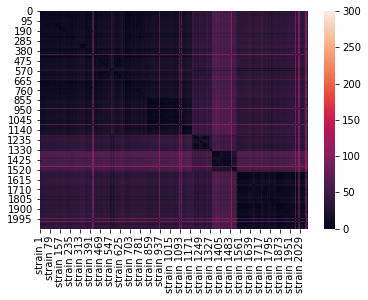

In [14]:
print(sns.heatmap(similarity_matrix,vmin=0, vmax=300))

# Reading in the Metadata
- The metadata is used for getting the region, country, etc of different strains. This data is used to color the clusters.
- The metadata contains all of the possible sampled strains, so many of these will not be in the genomes from the aligned file, probably because the strains were corrupted, too short, etc. 
- We merge this metadata with the strains we have in the aligned file to get a list of all of the strains that match between both. It should come out to the amount of strains in the aligned file.

In [15]:
#merging my final dataframe with their regions and strain names
pathMeta = Path.cwd().joinpath("Data", "metadata_h3n2_ha.tsv")
metadata_df = pd.read_csv(pathMeta, delimiter='\t')

In [16]:
metadata_df.head()

,strain,virus,accession,date,region,country,division,location,passage,authors,age,gender
0,A/Abakan/249/2018,flu,EPI1318896,2018-03-13,?,?,?,?,cell,state_research_center_of_virology_and_biotechn...,41y,female
1,A/Aberaeron/5961/2018,flu,EPI1227236,2018-03-12,europe,united_kingdom,wales,aberaeron,unpassaged,public_health_wales_microbiology,46y,male
2,A/Aberdare/1604/2018,flu,EPI1275673,2018-02-27,?,?,?,?,unpassaged,public_health_wales_microbiology,74y,female
3,A/Aberdare/588/2019,flu,EPI1414271,2019-02-11,europe,united_kingdom,wales,aberdare,unpassaged,public_health_wales_microbiology_cardiff,57y,female
4,A/Aberdare/632/2019,flu,EPI1414286,2019-02-13,europe,united_kingdom,wales,aberdare,unpassaged,public_health_wales_microbiology_cardiff,62y,male


In [17]:
metadata_df.shape

(68655, 12)

In [18]:
#making a dataframe out of the strains from the alignment file to merge with the metadata
strains_df = pd.DataFrame(strains)
strains_df.columns = ['strain']

In [19]:
strains_df.shape

(2085, 1)

In [20]:
#Merging strains and metadata 
result_strains = pd.merge(strains_df,metadata_df, on='strain')

In [21]:
#checking that no strains were lost
result_strains.shape

(2085, 12)

In [22]:
result_strains.head()

,strain,virus,accession,date,region,country,division,location,passage,authors,age,gender
0,A/Oman/5263/2017,flu,EPI1088172,2017-09-25,west_asia,oman,oman,oman,unpassaged,centers_for_disease_control_and_prevention,16y,male
1,A/Oman/5101/2017,flu,EPI1088180,2017-09-27,west_asia,oman,oman,oman,unpassaged,centers_for_disease_control_and_prevention,9y,male
2,A/Madagascar/424/2018,flu,EPI1282667,2018-02-06,africa,madagascar,madagascar,madagascar,cell,centers_for_disease_control_and_prevention,13y,male
3,A/Phetchaburi/104/2018,flu,EPI1281505,2018-05-27,southeast_asia,thailand,phetchaburi,phetchaburi,cell,who_collaborating_centre_for_reference_and_res...,33y,female
4,A/Philippines/160/2018,flu,EPI1266221,2018-02-05,southeast_asia,philippines,philippines,philippines,unpassaged,centers_for_disease_control_and_prevention,2y,female


In [23]:
np.setdiff1d(strains_df['strain'].unique(),metadata_df['strain'].unique())

array([], dtype=object)

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- I opened and imported the json from a build from NextStrain ([flu][2], [zika][3], etc)
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html
[2]: https://github.com/nextstrain/seasonal-flu
[3]: https://altair-viz.github.io/index.html

In [24]:
with open('Data/flu_seasonal_h3n2_ha_2y_tree.json') as fh:
    json_tree_handle = json.load(fh)

In [25]:
tree = json_to_tree(json_tree_handle)

In [26]:
tree

Clade(branch_length=0, clade=3769, name='NODE_0002093', numdate=2012.5519511386733, strain='NODE_0002093', yvalue=1985.2580021129058)

In [27]:
node_data = [
    {
        "strain": node.name,
        "date": node.attr["num_date"],
        "y": node.yvalue,
        "region": node.attr["region"],
        "country": node.attr["country"],
        "parent_date": node.parent is not None and node.parent.attr["num_date"] or node.attr["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue,
        "clade_membership" : node.attr['clade_membership']
    }
    for node in tree.find_clades(terminal=True)
]

In [28]:
node_data[10]

{'strain': 'A/Texas/88/2016',
 'date': 2016.1505817932923,
 'y': 2083,
 'region': 'north_america',
 'country': 'usa',
 'parent_date': 2015.1390475527255,
 'parent_y': 2082.25,
 'clade_membership': '3c3.A'}

In [29]:
node_df = pd.DataFrame(node_data)

In [30]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership
0,A/Almaty/2958/2013,2013.073922,2093,west_asia,kazakhstan,2012.995475,2091.519618,3c3
1,A/Victoria/505/2013,2013.459959,2092,oceania,australia,2013.293896,2091.500000,3c3
2,A/Newcastle/22/2014,2014.457221,2091,oceania,australia,2013.293896,2091.500000,3c3.B
3,A/Stockholm/6/2014,2014.101300,2090,europe,sweden,2013.840269,2088.578472,3c3.A
4,A/Switzerland/9715293/2013,2013.930869,2089,europe,switzerland,2013.930869,2087.156945,3c3.A


In [31]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [32]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [33]:
node_df.shape

(2093, 8)

In [34]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership
0,A/Almaty/2958/2013,2013.073922,0,west_asia,kazakhstan,2012.995475,0.000000,3c3
1,A/Victoria/505/2013,2013.459959,1,oceania,australia,2013.293896,0.019618,3c3
2,A/Newcastle/22/2014,2014.457221,2,oceania,australia,2013.293896,0.019618,3c3.B
3,A/Stockholm/6/2014,2014.101300,3,europe,sweden,2013.840269,2.941146,3c3.A
4,A/Switzerland/9715293/2013,2013.930869,4,europe,switzerland,2013.930869,4.362673,3c3.A


In [35]:
node_df["region"].unique()

array(['west_asia', 'oceania', 'europe', 'japan_korea', 'china',
       'north_america', 'south_america', 'africa', 'south_asia',
       'southeast_asia'], dtype=object)

In [36]:
node_numpy = node_df['clade_membership'].to_numpy()
clade_ok = []
clades = ['3c3.A', 'A1b/131K', 'A1b/135K', 'A2/re', 'A2', 'A3']
#node_numpy = node_numpy.tolist()
for node in node_numpy:
    if node not in clades:
        clade_ok.append("other")
    else:
        clade_ok.append(node)

In [37]:
clade_new = pd.DataFrame(clade_ok)
node_df = node_df.merge(clade_new, how='outer', left_index=True, right_index=True)

In [38]:
node_df.head()

,strain,date,y,region,country,parent_date,parent_y,clade_membership,0
0,A/Almaty/2958/2013,2013.073922,0,west_asia,kazakhstan,2012.995475,0.000000,3c3,other
1,A/Victoria/505/2013,2013.459959,1,oceania,australia,2013.293896,0.019618,3c3,other
2,A/Newcastle/22/2014,2014.457221,2,oceania,australia,2013.293896,0.019618,3c3.B,other
3,A/Stockholm/6/2014,2014.101300,3,europe,sweden,2013.840269,2.941146,3c3.A,3c3.A
4,A/Switzerland/9715293/2013,2013.930869,4,europe,switzerland,2013.930869,4.362673,3c3.A,3c3.A


In [39]:
node_df.columns = ['strain', 'date', 'y', 'region', 'country', 'parent_date',
      'parent_y', 'clade_membership', 'clade_membership_color']

## Checking for Outliers in Pairwise Distance

In [50]:
result_df = pd.DataFrame(result_strains['strain'])
index_df = pd.DataFrame(similarity_matrix.mean().index)
result_index_df = result_df.set_index(similarity_matrix.mean().index)
mean_similarity_matrix = pd.DataFrame(similarity_matrix.mean())

In [51]:
result_index_df = result_index_df.merge(mean_similarity_matrix, left_index=True, right_index=True)
result_index_df.columns = ["strain","mean"]
result_index_df

,strain,mean
strain 1,A/Oman/5263/2017,24.521343
strain 2,A/Oman/5101/2017,23.664269
strain 3,A/Madagascar/424/2018,26.406715
strain 4,A/Phetchaburi/104/2018,23.973621
strain 5,A/Philippines/160/2018,22.982734
...,...,...
strain 2081,A/SaoPaulo/706496/2018,87.680096
strain 2082,A/Perth/151/2018,33.062830
strain 2083,A/Concepcion/87275/2018,33.844604
strain 2084,A/Kaliningrad/17/2018,37.717986


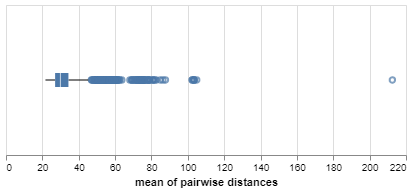

In [52]:
alt.Chart(result_index_df,height=150).mark_boxplot().encode(
    x = alt.X('mean',title="mean of pairwise distances"),
    tooltip = ["strain"]
)

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [ ]:
numbers = genomes[:]
for i in range(0,len(genomes)):
    numbers[i] = re.sub(r'[^AGCT]', '5', numbers[i])
    numbers[i] = list(numbers[i].replace('A','1').replace('G','2').replace('C', '3').replace('T','4'))
    numbers[i] = [int(j) for j in numbers[i]]
genomes_df = pd.DataFrame(numbers)
genomes_df.columns = ["Site " + str(k) for k in range(0,len(numbers[i]))]

In [ ]:
genomes_df.head()

In [ ]:
#performing PCA on my pandas dataframe 
pca = PCA(n_components=10,svd_solver='full') #can specify n, since with no prior knowledge, I use None
principalComponents = pca.fit_transform(genomes_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component " + str(i) for i in range(1,11)])

In [ ]:
df = pd.concat([pd.DataFrame(np.arange(1,11)), pd.DataFrame([round(pca.explained_variance_ratio_[i],4) for i in range(0,len(pca.explained_variance_ratio_))])], axis = 1)
df.columns = ['principal components','explained variance']
df

In [ ]:
alt.Chart(df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q')

In [ ]:
principalDf.head()

# Merging Strain and PCA

In [ ]:
strains_df = pd.DataFrame(strains)
strains_df.columns = ['strain']

In [ ]:
result_strains = pd.merge(strains_df,metadata_df, on='strain')

In [ ]:
finalDf = pd.concat([principalDf, result_strains[['region','country','strain']]], axis = 1)

In [ ]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [ ]:
merged_df.head()

In [ ]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [ ]:
merged_df.head()

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_df,['principal component 1','principal component 2','principal component 3','principal component 4'],
                                         ['Principal Component 1 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                                          'Principal Component 2 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                                          'Principal Component 3 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                                          'Principal Component 4 (Explained Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")"],
                                         "clade_membership:N",['strain','region'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

# Running MDS on the Dataset

In [ ]:
embedding = MDS(n_components=10,metric=True,dissimilarity='precomputed')
X_transformed = embedding.fit_transform(similarity_matrix)

In [ ]:
raw_stress = embedding.stress_
normalized_stress = np.sqrt(raw_stress /((similarity_matrix.values.ravel() ** 2).sum() / 2))
print(normalized_stress.round(2))

In [ ]:
MDS_df = pd.DataFrame(X_transformed,columns=['MDS cluster ' + str(i) for i in range(1,11)])
print(MDS_df.head())

In [ ]:
finalDf = concatenate_results_with_strain_data(MDS_df, node_df, ['strain','clade_membership', 'clade_membership_color'])

In [ ]:
finalDf.columns

In [ ]:
finalDf.head()

In [ ]:
merged_df = pd.merge(finalDf,node_df,on=["strain",'clade_membership_color','clade_membership']).dropna()

In [ ]:
merged_df.columns

In [ ]:
scatterplot_with_tooltip_interactive(merged_df,'MDS cluster 1','MDS cluster 2',"MDS cluster 1","MDS cluster 2",['strain','clade_membership'],'clade_membership_color')

In [ ]:
scatterplot_with_tooltip_interactive(merged_df,'MDS cluster 3','MDS cluster 4',"MDS cluster 3","MDS cluster 4",['strain','clade_membership'],'clade_membership_color')

In [ ]:
scatterplot_tooltips(similarity_matrix, merged_df, "MDS cluster 1", "MDS cluster 2", "MDS")

In [ ]:
scatterplot_tooltips(similarity_matrix, merged_df, "MDS cluster 3", "MDS cluster 4", "MDS")

In [ ]:
scatterplot_tooltips(similarity_matrix, merged_df, "MDS cluster 5", "MDS cluster 6", "MDS")

In [ ]:
scatterplot_with_tooltip_interactive(merged_df,'MDS cluster 5','MDS cluster 6',"MDS cluster 5","MDS cluster 6",['strain','clade_membership'],'clade_membership_color')

# Linking Tree to MDS plot

In [ ]:
list_of_data_and_titles = ['MDS cluster 1','MDS cluster 2','MDS cluster 3','MDS cluster 4','MDS cluster 5','MDS cluster 6']
list_of_chart = linking_tree_with_plots_brush(merged_df,list_of_data_and_titles,list_of_data_and_titles,'clade_membership_color',["clade_membership","strain:N"])
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]
chart

In [ ]:
data = linking_tree_with_plots_clickable(merged_df,['MDS cluster 1','MDS cluster 2','MDS cluster 3','MDS cluster 4','MDS cluster 5','MDS cluster 6'],['MDS cluster 1','MDS cluster 2','MDS cluster 3','MDS cluster 4','MDS cluster 5','MDS cluster 6'],'clade_membership_color:N',['clade_membership'],["clade_membership:N","strain:N"])

chart = data[0]|data[1]|data[2]|data[3]|data[4]
chart

In [ ]:
chart.save("../Docs/MDSFluBrush.html")

# Running T-SNE on the Dataset 

In [ ]:
embedding = TSNE(n_components=2,metric='precomputed',perplexity = 25.95)
X_transformed = embedding.fit_transform(similarity_matrix)

In [ ]:
TSNE_df = pd.DataFrame(X_transformed,columns=['TSNE cluster ' + str(i) for i in range(1,3)])
print(TSNE_df.head())

In [ ]:
finalDf = concatenate_results_with_strain_data(TSNE_df,result_strains,['strain','region'])

In [ ]:
finalDf.shape

In [ ]:
merged_df = pd.merge(finalDf,node_df,on=["strain"]).dropna()

In [ ]:
merged_df.columns

In [ ]:
scatterplot_tooltips(similarity_matrix, merged_df, "TSNE cluster 1", "TSNE cluster 2", "TSNE")

In [ ]:
scatterplot_with_tooltip_interactive(merged_df,'TSNE cluster 1','TSNE cluster 2',"TSNE cluster 1","TSNE cluster 2",['strain','clade_membership'],'clade_membership_color')

# Linking Tree to T-SNE plot

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_df,['TSNE cluster 1','TSNE cluster 2'],['TSNE cluster 1','TSNE cluster 2'],'clade_membership_color',["clade_membership:N","strain:N"])
chart = list_of_chart[0]|list_of_chart[1]
chart

In [ ]:
data = linking_tree_with_plots_clickable(merged_df,['TSNE cluster 1','TSNE cluster 2'],['TSNE cluster 1','TSNE cluster 2'],'clade_membership_color:N',['clade_membership'],["clade_membership:N","strain:N"])

chart = data[0]|data[1]|data[2]
chart

In [ ]:
chart.save("../Docs/TSNEFluClickable.html")

# Running UMAP on the Dataset

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(similarity_matrix)

In [ ]:
UMAP_df = pd.DataFrame(embedding,columns=['UMAP cluster ' + str(i) for i in range(1,3)])
print(UMAP_df.head())

In [ ]:
finalDf = concatenate_results_with_strain_data(UMAP_df, result_strains, ['strain','region','country'])

In [ ]:
finalDf.shape

In [ ]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [ ]:
merged_df.shape

In [ ]:
scatterplot_tooltips(similarity_matrix, merged_df, "UMAP cluster 1", "UMAP cluster 2", "UMAP")

In [ ]:
scatterplot_with_tooltip_interactive(merged_df,'UMAP cluster 1','UMAP cluster 2',"UMAP cluster 1","UMAP cluster 2",['strain','clade_membership'],'clade_membership_color')

# Linking Tree with UMAP plot

In [ ]:
list_of_data_and_titles = ['UMAP cluster 1','UMAP cluster 2']
list_of_chart = linking_tree_with_plots_brush(merged_df,list_of_data_and_titles,list_of_data_and_titles,'clade_membership_color',["clade_membership","strain:N"])
chart = list_of_chart[0]|list_of_chart[1]
chart

In [ ]:
chart.save("../Docs/UMAPFluBrush.html")

# Linking all plots together clickable with Tree

In [ ]:
together_df = MDS_df.merge(TSNE_df, how='outer', left_index=True, right_index=True)
together_df = together_df.merge(principalDf, how='outer', left_index=True, right_index=True)
together_df = together_df.merge(UMAP_df, how='outer', left_index=True, right_index=True)
together_df.head()

In [ ]:
finalDf = concatenate_results_with_strain_data(together_df, result_strains, ['strain','region','country'])

In [ ]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [ ]:
merged_df.columns

In [ ]:
data = linking_tree_with_plots_clickable(merged_df,['MDS cluster 1', 'MDS cluster 2','TSNE cluster 1', 'TSNE cluster 2', 'principal component 1', 'principal component 2', 'UMAP cluster 1', 'UMAP cluster 2'], ['MDS cluster 1', 'MDS cluster 2', 'TSNE cluster 1', 'TSNE cluster 2','Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",'UMAP cluster 1','UMAP cluster 2'],'clade_membership_color:N',['clade_membership'],['strain','clade_membership'])

In [ ]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart.save('../Docs/FullLinkedChartClickable.html')
fullChart

# Notes to Self:

- Collapse cells underneath Markdown headers
- Get docstrings above methods to show up when user presses SHIFT + TAB
- link back to the methods section for user each time method is used
- Run more Flu builds (3 years, 6 years, 12 years, H3, H1)
- Try algorithm on MERS
- Try algorithm on other bacterial genomes (unaligned / small snips of genomes)
- Make Zika clades or run automatic clade naming on 12y H3N2 flu with different cutoffs to standardize coloring for graphs
- Write a paper
